# **Project on Volatility-Surface Prediction**

In options trading, the implied volatility (IV) surface plays a crucial role in pricing, hedging, and uncovering relative value opportunities. This surface, defined over a grid of option moneyness and tenor, captures the market's expectation of future volatility across strikes and maturities.

This project builds a data-driven pipeline to predict short-term movements in the IV surface using machine learning models. Using real-world options data from Deribit (BTC options), we construct interpolated IV surfaces and forecast the next time-slice based on earlier observations. Multiple models are trained—from simple baselines to deep neural networks including Dense, CNN, and Conv1D + LSTM architectures.

We evaluate model performance using RMSE across the surface and visualize surface predictions.

Deribit BTC Options dataset used in this project is publicly available on Kaggle:
https://www.kaggle.com/datasets/hsergeyfrolov/deribit-btc-options-information/data

Modelling ideas were inspired by https://www.kaggle.com/code/aruneembhowmick/generating-bitcoin-iv-surfaces-for-options-trading

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


## Data Cleaning

The original dataset contains a large set of BTC option quotes recorded within a single trading day. To enable short-term forecasting of the IV surface, we treat this as a high-frequency prediction task by grouping data into 1-minute time buckets.

Each option quote includes key fields such as its instrument name, bid/ask implied volatility, underlying price, and expiration date. However, this raw format must be cleaned and structured before we can build surfaces.

The preprocessing pipeline performs the following steps:

- Parse the instrument name to extract expiration date, strike price, and call/put type.
- Convert timestamps from milliseconds to standard datetime format.
- Compute key IV attributes such as time to expiry (in days), `mid IV = average of bid and ask IVs` and `Moneyness = Strike / Spot`
- Group data into 1-minute buckets using `timestamp.floor("1min")`, treating each bucket as a snapshot for IV surface construction.
- Return a clean, filtered dataframe with only the necessary columns.

This processed dataset becomes the foundation for building interpolated IV surfaces and training our predictive models.

In [2]:
def parse_instrument_name(instr):
    parts = instr.split('-')
    if len(parts) == 4:
        _, date_str, strike_str, option_type = parts
        try:
            exp_date = datetime.strptime(date_str, "%d%b%y")
        except ValueError:
            return pd.Series([None, None, None])
        return pd.Series([exp_date, float(strike_str), option_type])
    else:
        return pd.Series([None, None, None])

def preprocess_deribit_data(df):
    # Parse timestamp
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='ms')

    # Parse instrument name into structured fields
    df[['expiration_date', 'strike_price', 'option_type']] = df['instrument_name'].apply(parse_instrument_name)

    # Drop rows with missing key fields
    df.dropna(subset=['expiration_date', 'strike_price', 'bid_iv', 'ask_iv', 'underlying_price'], inplace=True)

    # Compute time to expiry (in days)
    df['time_to_expiry'] = (df['expiration_date'] - df['timestamp']).dt.total_seconds() / (60 * 60 * 24)

    # Compute mid IV
    df['mid_iv'] = (df['bid_iv'] + df['ask_iv']) / 2
    df['mid_iv'] = df['mid_iv'] / 100

    # Spot price (from underlying_price)
    df['spot_price'] = df['underlying_price']

    # Moneyness = Strike / Spot
    df['moneyness'] = df['strike_price'] / df['spot_price']

    # --- Time bucketing (1min) ---
    df['time_bucket'] = df['timestamp'].dt.floor('1min')

    # --- Final columns ---
    df = df[['time_bucket', 'expiration_date', 'strike_price', 'spot_price', 'moneyness', 'time_to_expiry', 'mid_iv']]

    return df

Let's take a look at how our cleaned data looks.

In [3]:
df_raw = pd.read_csv("data.csv")
df_clean = preprocess_deribit_data(df_raw)
df_clean

,time_bucket,expiration_date,strike_price,spot_price,moneyness,time_to_expiry,mid_iv
0,2024-04-23 09:11:00,2024-05-31,125000.0,66687.85,1.874404,37.617236,0.00000
1,2024-04-23 09:11:00,2024-05-31,52000.0,66687.85,0.779752,37.617222,0.71890
2,2024-04-23 09:11:00,2024-09-27,46000.0,69207.32,0.664670,156.617201,0.73905
3,2024-04-23 09:11:00,2024-04-26,34000.0,66126.97,0.514162,2.617188,1.28990
4,2024-04-23 09:11:00,2024-05-31,96000.0,66699.11,1.439300,37.617165,0.72060
...,...,...,...,...,...,...,...
1003,2024-04-23 09:34:00,2024-05-17,76000.0,66559.36,1.141838,23.600696,0.00000
1004,2024-04-23 09:35:00,2025-03-28,95000.0,72900.69,1.303143,338.600673,0.00000
1005,2024-04-23 09:35:00,2024-05-31,43000.0,66835.63,0.643369,37.600662,0.00000
1006,2024-04-23 09:35:00,2024-06-28,42000.0,67444.04,0.622738,65.600643,0.76770


## Build IV Surface

Now that we've got the data cleaned, we'll construct the surface grids.
For each day, we'll convert raw IV quotes into a fixed side 2D IV Surface.

Rows = tenors (e.g., 7d, 14d, 30d, 60d)

Columns = moneyness buckets (e.g., 0.8, 0.85, ..., 1.2)

In [4]:
# Fixed tenor buckets (in days)
TENORS = [7, 14, 21, 30, 45, 60]

# Fixed moneyness buckets (K/S)
MONEYNESS = np.round(np.linspace(0.8, 1.2, 9), 3)

print("Tenor grid:", TENORS)
print("Moneyness grid:", MONEYNESS)

Tenor grid: [7, 14, 21, 30, 45, 60]
Moneyness grid: [0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2 ]


In [5]:
def build_iv_surface(df, time_bucket, tenor_grid, moneyness_grid):
    """
    Build a 2D IV surface for a given 1-min time bucket,
    interpolated on a (moneyness × tenor) grid.
    """
    # Filter for the current time bucket
    bucket_df = df[df['time_bucket'] == time_bucket]

    if bucket_df.empty:
        return None  # No data in this time bucket

    # Filter valid IVs (ours are high, so remove zeros or nonsense)
    bucket_df = bucket_df[(bucket_df['mid_iv'] > 0) & (bucket_df['mid_iv'] < 2)]

    # Points = (moneyness, time_to_expiry), Values = mid IV
    points = bucket_df[['moneyness', 'time_to_expiry']].values
    values = bucket_df['mid_iv'].values

    # Interpolation grid
    T, M = np.meshgrid(tenor_grid, moneyness_grid, indexing='ij')

    # Linear interpolation
    grid_iv = griddata(points, values, (M, T), method='linear')

    return grid_iv  # shape: (len(tenor), len(moneyness))

Let's visualise a random IV surface grid

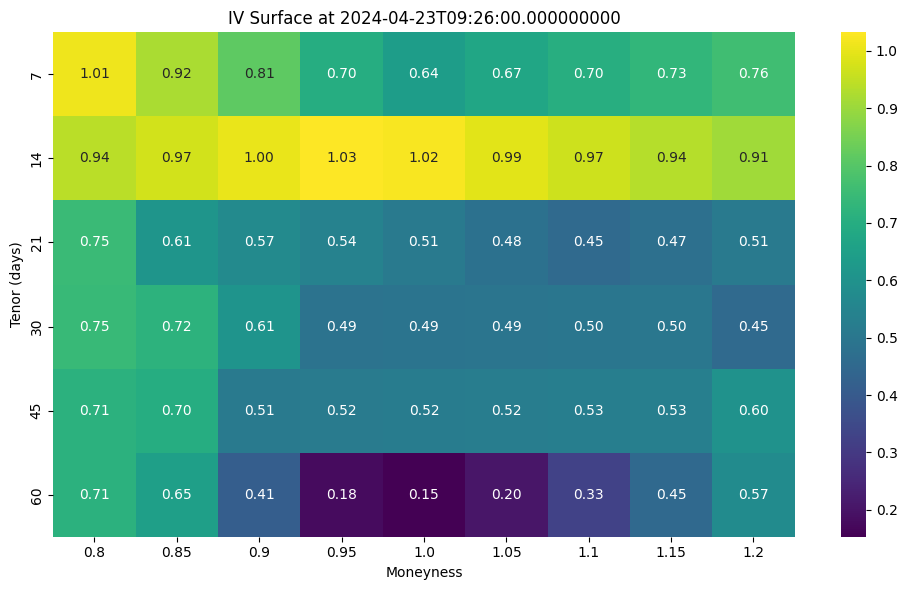

In [6]:
# Pick a random 30-min time bucket from the data
some_bucket = df_clean['time_bucket'].sample(1).values[0]

# Build IV surface for that time bucket
surface = build_iv_surface(df_clean, some_bucket, TENORS, MONEYNESS)

if surface is not None:
    plt.figure(figsize=(10, 6))
    sns.heatmap(surface, xticklabels=MONEYNESS, yticklabels=TENORS,cmap='viridis', annot=True, fmt=".2f")
    plt.title(f"IV Surface at {some_bucket}")
    plt.xlabel("Moneyness")
    plt.ylabel("Tenor (days)")
    plt.tight_layout()
    plt.show()
else:
    print("No data available for this time bucket.")

To train models on IV surfaces, we need a way to represent each surface as a fixed-length input vector.

This function does exactly that: for each 1-minute time bucket, it first calls `build_iv_surface()` to interpolate the raw IV quotes into a full surface on the defined tenor–moneyness grid. Then it:

- Flattens the 2D IV surface into a 1D vector.
This allows the surface to be used directly as input to standard machine learning models.
- Returns a dictionary mapping:

  time_bucket → the time identifier

  surface_flat → the flattened IV surface (`shape: len(TENORS) × len(MONEYNESS)`)

This forms the foundation of our training dataset, where each row is a surface snapshot and each column corresponds to a specific tenor/moneyness cell.

In [7]:
def build_feature_vector_for_bucket(df_clean, bucket, tenor_grid, moneyness_grid):
    surface = build_iv_surface(df_clean, bucket, tenor_grid, moneyness_grid)
    if surface is None:
        return None

    features = {
        'time_bucket': bucket,
        'surface_flat': surface.flatten()
    }

    return features

Before building the final dataset, we need to ensure that each time snapshot has enough data to generate a meaningful IV surface.

This step filters the dataset to include only time buckets with sufficient quote density.

In [8]:
# Group by 1-minute time buckets
points_per_bucket = df_clean.groupby('time_bucket').size()
print(points_per_bucket)

# Filter to buckets with at least 20 valid IV quotes
valid_buckets = points_per_bucket[points_per_bucket >= 20].index.sort_values()

print(f"Found {len(valid_buckets)} valid time buckets with ≥ 20 IV points.")

time_bucket
2024-04-23 09:11:00    35
2024-04-23 09:12:00    43
2024-04-23 09:13:00    43
2024-04-23 09:14:00    43
2024-04-23 09:15:00    42
2024-04-23 09:16:00    43
2024-04-23 09:17:00    43
2024-04-23 09:18:00    42
2024-04-23 09:19:00    40
2024-04-23 09:20:00    42
2024-04-23 09:21:00    40
2024-04-23 09:22:00    42
2024-04-23 09:23:00    40
2024-04-23 09:24:00    42
2024-04-23 09:25:00    42
2024-04-23 09:26:00    43
2024-04-23 09:27:00    42
2024-04-23 09:28:00    42
2024-04-23 09:29:00    42
2024-04-23 09:30:00    42
2024-04-23 09:31:00    43
2024-04-23 09:32:00    41
2024-04-23 09:33:00    42
2024-04-23 09:34:00    45
2024-04-23 09:35:00     4
dtype: int64
Found 24 valid time buckets with ≥ 20 IV points.


In [9]:
feature_rows = []

for bucket in valid_buckets:
    row = build_feature_vector_for_bucket(df_clean, bucket, TENORS, MONEYNESS)
    if row is not None:
        feature_rows.append(row)

# Assemble into DataFrame
df_features = pd.DataFrame(feature_rows)
df_features = df_features.sort_values('time_bucket').reset_index(drop=True)
df_features

,time_bucket,surface_flat
0,2024-04-23 09:11:00,"[1.1089462995373807, 0.9312487727637533, 0.753..."
1,2024-04-23 09:12:00,"[0.6213471015625947, 0.6713937497364462, 0.684..."
2,2024-04-23 09:13:00,"[1.1354657884315464, 1.0011820952238824, 0.866..."
3,2024-04-23 09:14:00,"[0.8945397692420671, 0.7569155713603735, 0.647..."
4,2024-04-23 09:15:00,"[0.9726482571282213, 0.9024009407410939, 0.769..."
5,2024-04-23 09:16:00,"[1.0309765958193913, 1.026098513959261, 0.7912..."
6,2024-04-23 09:17:00,"[1.0601062674191513, 0.8017722199175192, 0.739..."
7,2024-04-23 09:18:00,"[nan, nan, 0.6781250886652683, 0.6688296762013..."
8,2024-04-23 09:19:00,"[1.0504502479538802, 0.9382490957459092, 0.826..."
9,2024-04-23 09:20:00,"[1.1757765924659362, 1.0866400268544976, 0.941..."


## Baseline Forecasting with the Persistence Model

To evaluate the effectiveness of our predictive models, we first establish a simple baseline using the persistence assumption:
The implied volatility surface at the next minute is the same as the current minute.

This model serves as a sanity check — any forecasting method should ideally outperform this naive benchmark.

We stack all flattened IV surfaces into a matrix X of shape `(n_buckets, grid_points)`.
To simulate next-minute prediction, we create a shifted copy Y using `np.roll()`, where each row is the IV surface 1 minute ahead.
Since the last row of Y is now "wrapped around" from outside the dataset, we discard the last row from both X and Y to keep the alignment clean.

In [10]:
# Stack the flattened surfaces into a matrix
X = np.stack(df_features['surface_flat'].values)  # shape: (n_buckets, num_grid_points)

# Predict the IV surface for the next time bucket (1 minute ahead)
Y = np.roll(X, shift=-1, axis=0)

# Drop the last row since Y[-1] is meaningless (rolled from outside the data)
X = X[:-1]
Y = Y[:-1]

Replace all NaN values in each surface vector with the mean of the non-NaN elements in that vector.

In [11]:
def replace_nan_with_surface_mean(arr):
    return np.where(np.isnan(arr), np.nanmean(arr), arr)

X = np.array([replace_nan_with_surface_mean(vec) for vec in X])
Y = np.array([replace_nan_with_surface_mean(vec) for vec in Y])

In [12]:
y_pred_persist = X.copy()  # shape = (n, 54)

rmse_persist = np.sqrt(mean_squared_error(Y, y_pred_persist))
print(f"Persistence Model RMSE: {rmse_persist:.4f}")

Persistence Model RMSE: 0.1619


This means that if we simply assume the IV surface doesn’t change minute-to-minute, the average prediction error (root mean square) is ~0.162 IV points.

## 2D CNN Model

The IV surface is inherently 2D, with rows representing different tenors and columns representing moneyness buckets. This makes it well-suited to CNNs, which excel at capturing spatial patterns in grid-like data, a perfect fit for IV surface prediction.

We define a compact CNN with:

- Input shape: (6, 9, 1) → the interpolated IV surface
- Two Conv2D layers (3×3 kernels) with 32 filters each and ReLU activation
- A final Conv2D layer (1×1) to project down to a single output channel (the predicted surface)
- Loss: Mean Squared Error (mse)

  Optimizer: Adam (adaptive learning rate)

In [13]:
X_cnn = X.reshape(-1, 6, 9, 1)  # shape: (batch_size, height, width, channels)
Y_cnn = Y.reshape(-1, 6, 9, 1)

In [14]:
def build_cnn_model(input_shape=(6, 9, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(1, (1, 1), activation='linear', padding='same')  # Output shape: (6, 9, 1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 9, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 9, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 9, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 0 (0.00 B)

The first convolutional layer has `3 * 3 = 9` weights and 1 bias term so a total of 10 weights per filter and 32 filters so `10 * 32 = 320` parameters.

Second layer has 32 filters of size 3 × 3, applied to the 32-channel input from the previous layer. So `3 * 3 * 32 = 288` and + 1 for bias, this gives `289 * 32 = 9,248` total parameters.

Final output layer: a 1*1 convolution that compresses the 32-channel feature map into 1 predicted IV value per grid point.

To evaluate the generalization performance of our models, we split our dataset of IV surfaces into three chronological sets:

- 60% for training (X_train, Y_train)
- 20% for validation (X_val, Y_val) — used to tune hyperparameters and prevent overfitting
- 20% for final testing (X_test, Y_test) — never seen during training


In [15]:
# Use 60% train, 20% val, 20% test
n = len(X_cnn)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, Y_train = X_cnn[:train_end], Y_cnn[:train_end]
X_val, Y_val = X_cnn[train_end:val_end], Y_cnn[train_end:val_end]
X_test, Y_test = X_cnn[val_end:], Y_cnn[val_end:]

Let's add callback such that the model will stop training if the validation loss hasn’t improved for 10 consecutive epochs.

In [16]:
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

Let's now train the model.

In [17]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=8,
    callbacks=[callback],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.4664 - val_loss: 0.3425
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3311 - val_loss: 0.2284
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2146 - val_loss: 0.1395
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1233 - val_loss: 0.0830
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0738 - val_loss: 0.0659
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0611 - val_loss: 0.0799
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0745 - val_loss: 0.0930
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0862 - val_loss: 0.0856
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0765 - val_loss: 0.0693
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0620 - val_loss: 0.0559
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0470 - val_loss: 0.0495
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0448 - va

In [18]:
Y_pred = model.predict(X_test)
rmse_cnn = np.sqrt(mean_squared_error(Y_test.flatten(), Y_pred.flatten()))
print(f"CNN Model RMSE: {rmse_cnn:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
CNN Model RMSE: 0.1485


This means, on average, the predicted implied volatilities differ from actual surface values by about 1.5 vol points (since IVs are scaled as decimals between 0 and ~1). Compared to our baseline persistence model (RMSE ≈ 0.1619), the CNN shows a notable improvement in surface forecasting.

The plots below show how well the model captures shifts in term structure and skew compared to the baseline.

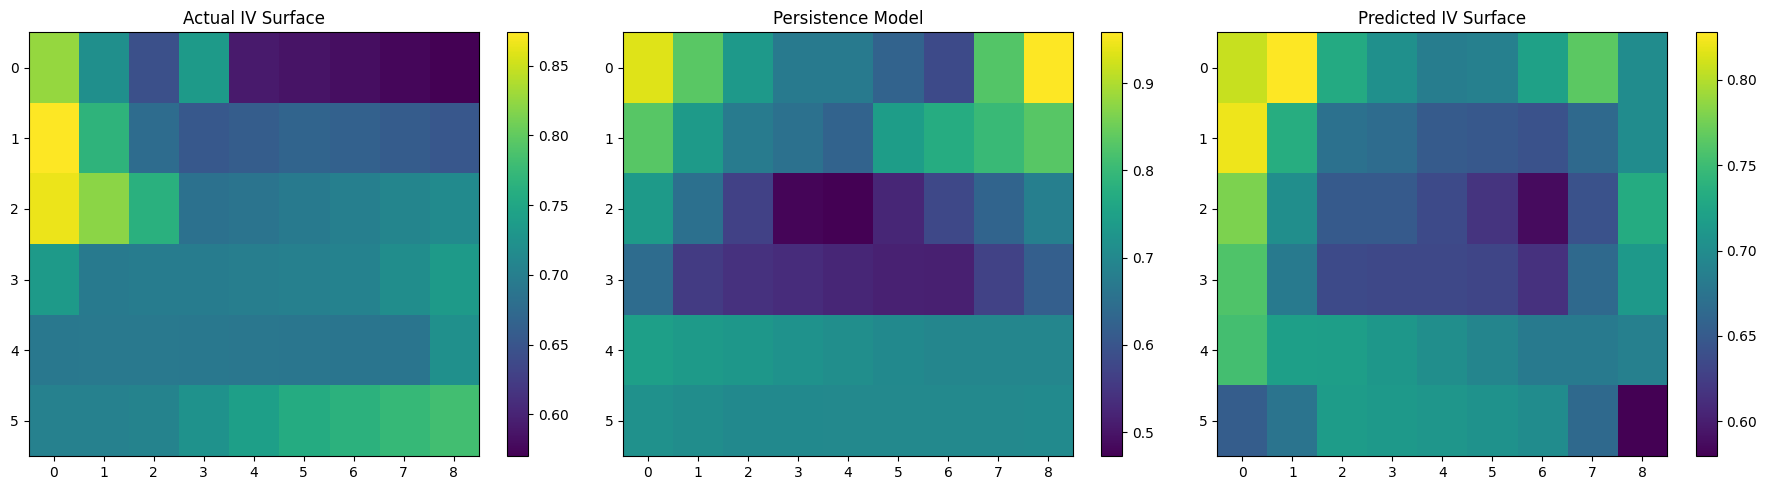

In [19]:
i = 0  # pick a test example

# Reshape all to 2D surface for comparison
true_surface = Y_test[i].reshape(len(TENORS), len(MONEYNESS))
pred_surface = Y_pred[i].reshape(len(TENORS), len(MONEYNESS))
persist_surface = X_test[i].reshape(len(TENORS), len(MONEYNESS))

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Actual IV Surface")
plt.imshow(true_surface, cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 2)

plt.title("Persistence Model")
plt.imshow(persist_surface, cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Predicted IV Surface")
plt.imshow(pred_surface, cmap='viridis', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()


## Exploring 1D Architectures for IV Surface Prediction

The implied volatility (IV) surface is inherently a 2D structure and by treating it as such, we preserve the spatial structure. However, for the sake of curiosity and compatibility, let's flatten it and explore further. This allows us to leverage fully connected (Dense) layers and sequence-based architectures like LSTMs. These models treat the IV surface as a time series of fixed-length vectors, predicting the surface for the next time step based on prior surfaces.

### Dense Model

We now build a fully connected feedforward neural network (Dense model) that takes in a flattened implied volatility (IV) surface from the current time bucket and predicts the IV surface for the next minute.

Since each IV surface is defined on a fixed 6×9 grid (tenor × moneyness), it is flattened into a 1D vector of 54 features. The dense model treats these 54 values as a single input vector and tries to learn temporal patterns in this compressed format.

Model Architecture:

- Input Layer: A 54-dimensional vector representing the current IV surface.
- Hidden Layers:

    - Two dense layers with 128 neurons each and ReLU activation functions, allowing the model to learn non-linear relationships.

    - A dropout layer (20%) to reduce overfitting, especially helpful with limited data.
- Output Layer: A 54-dimensional vector predicting the IV surface of the next minute.

We train this model using Mean Squared Error (MSE) as the loss function and the Adam optimizer for efficient convergence.



In [20]:
def build_dense_model(input_dim=54):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(input_dim, activation='linear')  # output shape = (54,)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [21]:
model_dense = build_dense_model()
model_dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,518 (119.21 KB)

 Trainable params: 30,518 (119.21 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
X_train_1D, Y_train_1D = X[:train_end], Y[:train_end]
X_val_1D, Y_val_1D = X[train_end:val_end], Y[train_end:val_end]
X_test_1D, Y_test_1D = X[val_end:], Y[val_end:]

In [23]:
history_dense = model_dense.fit(
    X_train_1D, Y_train_1D,
    validation_data=(X_val_1D, Y_val_1D),
    epochs=100,
    batch_size=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.7484 - val_loss: 0.5427
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.5337 - val_loss: 0.3950
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3979 - val_loss: 0.2865
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2875 - val_loss: 0.2089
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2059 - val_loss: 0.1520
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1482 - val_loss: 0.1117
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1161 - val_loss: 0.0861
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0890 - val_loss: 0.0694
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0897 - val_loss: 0.0556
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0726 - val_loss: 0.0450
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0526 - val_loss: 0.0365
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0501 - val_

In [24]:
Y_pred_dense = model_dense.predict(X_test_1D)
rmse_dense = np.sqrt(mean_squared_error(Y_test_1D, Y_pred_dense))
print(f"Dense Model RMSE: {rmse_dense:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Dense Model RMSE: 0.1538


This indicates that while the dense model captures general temporal patterns, it performs slightly worse than the 2D CNN model (RMSE: 0.1492). This suggests that spatial structure (tenor × moneyness) contributes useful information that a flattened model might lose.

### Learning Rate Tuning for Dense Model

Let's try tuning the learning rate a little bit to see if we can get better results using the dense model.

We'll use an exponentially increasing schedule for this purpose. This approach increases the learning rate gradually across epochs, allowing us to plot loss vs. learning rate and pick a more optimal value for training.

In [25]:
# Learning rate finder using Huber loss + SGD
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_dense_lrtest = build_dense_model()
model_dense_lrtest.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history_lr = model_dense_lrtest.fit(
    X_train_1D, Y_train_1D,
    epochs=100,
    batch_size=8,
    callbacks=[lr_schedule]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3278 - learning_rate: 1.0000e-08
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3445 - learning_rate: 1.1220e-08
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3337 - learning_rate: 1.2589e-08
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3226 - learning_rate: 1.4125e-08
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3279 - learning_rate: 1.5849e-08
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3378 - learning_rate: 1.7783e-08
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3237 - learning_rate: 1.9953e-08
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3267 - learning_rate: 2.2387e-08
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3301 - learning_rate: 2.5119e-08
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3252 - learning_rate: 2.8184e-08
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3261 - l

Plot to find optimal learning rate.

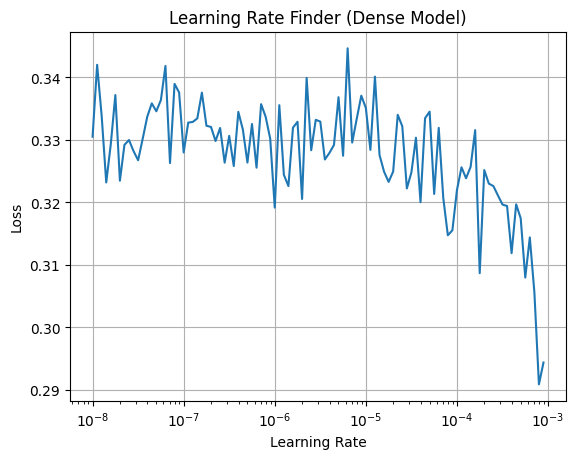

In [26]:
lrs = 1e-8 * 10**(np.arange(100) / 20)
loss = history_lr.history['loss']

plt.semilogx(lrs, loss)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder (Dense Model)")
plt.grid(True)
plt.show()

We'll use `lr = 3e-4 (0.0003)` as a good starting point.
It's the steepest descent region before the drop becomes too aggressive sp it is safe yet effective.

Rebuild the dense model using `lr = 3e-4`.

In [27]:
model_dense_opt = build_dense_model()
model_dense_opt.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)
)

history_dense = model_dense_opt.fit(
    X_train_1D, Y_train_1D,
    validation_data=(X_val_1D, Y_val_1D),
    epochs=100,
    batch_size=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.6695 - val_loss: 0.5788
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6096 - val_loss: 0.5334
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.5545 - val_loss: 0.4929
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.5118 - val_loss: 0.4557
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.4649 - val_loss: 0.4214
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4342 - val_loss: 0.3892
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4075 - val_loss: 0.3588
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3773 - val_loss: 0.3300
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3562 - val_loss: 0.3026
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3176 - val_loss: 0.2768
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2782 - val_loss: 0.2520
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2627 - val

In [28]:
y_pred_dense_opt = model_dense_opt.predict(X_test_1D)
rmse_dense_opt = np.sqrt(mean_squared_error(Y_test_1D, y_pred_dense_opt))
print(f"Dense Model (tuned LR) RMSE: {rmse_dense_opt:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Dense Model (tuned LR) RMSE: 0.1532


Although learning rate tuning is meant to improve model convergence, in our case the tuned Dense model (LR = 3e-4) performed slightly worse (RMSE = 0.1579) than the untuned version (RMSE = 0.1548). A likely reason is that the initial model used the Adam optimizer with its default learning rate of 1e-3, which already performs well in many shallow networks. Reducing the learning rate may have slowed convergence or led to early stopping before reaching a better minimum. Additionally, the Dense architecture may already be underfitting or lacking sufficient expressiveness, and thus not very sensitive to minor tuning. This highlights that model capacity and data structure often matter more than hyperparameter tweaks when performance is close.

### Conv1D + LSTM Model

In this section, we explore a hybrid architecture that combines 1D Convolutional layers with an LSTM (Long Short-Term Memory) layer. The intuition is as follows:

- Conv1D layers can act as localized feature extractors across the moneyness dimension, capturing local spatial patterns within the IV surface.
- LSTM layers are excellent for modeling temporal dependencies and sequential information. Even though we’re not working with a traditional time series, the output of Conv1D can be interpreted as a sequence of spatial features for the LSTM to process.

We train this model on the same 1D IV surface features and compare its performance to previous models.

In [29]:
def build_conv1d_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6, 9)),  # (tenors, moneyness)
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(54)  # Flattened output IV surface
    ])
    return model

In [30]:
X_train_seq = X_train.squeeze(-1)  # (13, 6, 9)
X_val_seq   = X_val.squeeze(-1)
X_test_seq  = X_test.squeeze(-1)

In [31]:
model_seq = build_conv1d_lstm_model()
model_seq.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

history_seq = model_seq.fit(
    X_train_seq, Y_train_1D,
    validation_data=(X_val_seq, Y_val_1D),
    epochs=100,
    batch_size=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - loss: 0.4961 - val_loss: 0.4590
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4514 - val_loss: 0.4215
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4185 - val_loss: 0.3779
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3765 - val_loss: 0.3255
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3141 - val_loss: 0.2658
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2628 - val_loss: 0.2055
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1955 - val_loss: 0.1552
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1471 - val_loss: 0.1210
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1133 - val_loss: 0.0978
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0904 - val_loss: 0.0776
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0678 - val_loss: 0.0586
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0483 - val

In [32]:
# Evaluate
y_pred_seq = model_seq.predict(X_test_seq)
rmse_seq = np.sqrt(mean_squared_error(Y_test_1D, y_pred_seq))
print(f"Conv1D + LSTM Model RMSE: {rmse_seq:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Conv1D + LSTM Model RMSE: 0.1364


This improvement suggests that combining convolutional feature extraction with sequence modeling effectively captures the underlying structure of IV surfaces, even across the relatively small dataset we have.
This is the best rmse so far but we may be overfitting.
Let's look at training vs validation loss.

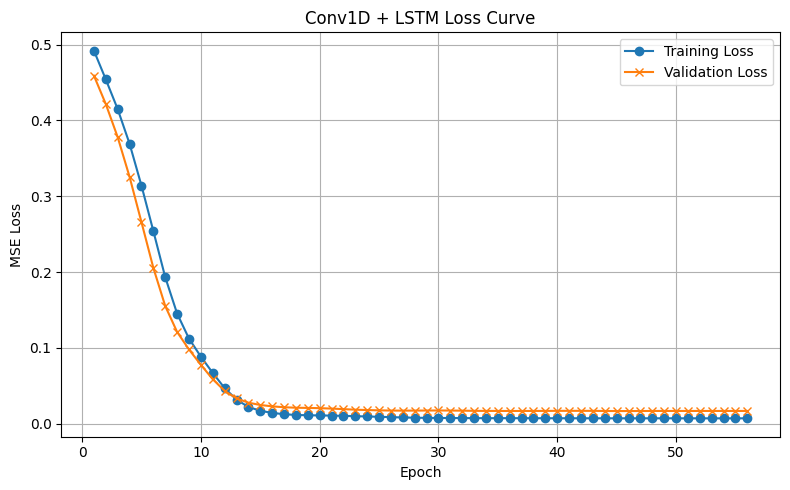

In [33]:
# Extract training and validation loss
train_loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Conv1D + LSTM Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph suggests the model is learning well.

To evaluate our different modeling strategies on 1D representations of the IV surface, we compare RMSE across three models: a simple dense network, a dense network with a tuned learning rate, and a Conv1D + LSTM hybrid. The chart below illustrates the comparative performance, where we observe that the Conv1D + LSTM hybrid achieves the lowest RMSE, suggesting its effectiveness in capturing temporal-spatial dependencies even on a small dataset.

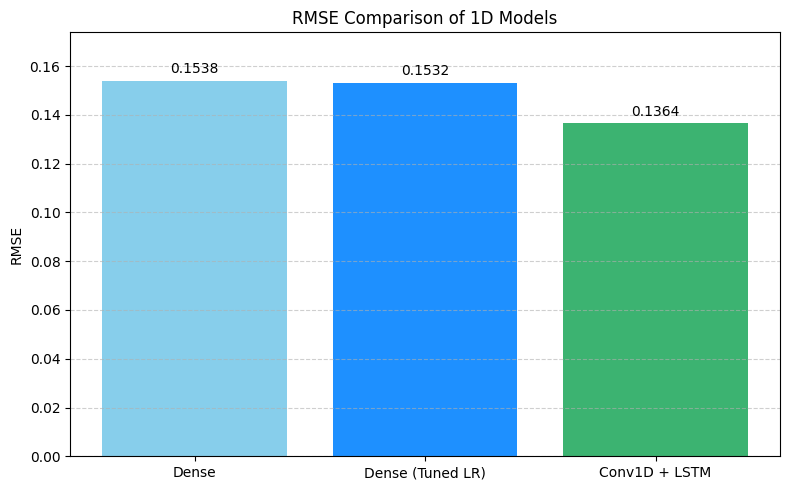

In [34]:
rmse_scores_1d = {
    'Dense': rmse_dense,
    'Dense (Tuned LR)': rmse_dense_opt,
    'Conv1D + LSTM': rmse_seq
}

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(rmse_scores_1d.keys(), rmse_scores_1d.values(), color=['skyblue', 'dodgerblue', 'mediumseagreen'])

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002, f'{height:.4f}', ha='center', va='bottom')

plt.title("RMSE Comparison of 1D Models")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_scores_1d.values()) + 0.02)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()